# Setup imports 

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sys import path
path.append('..')
from functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters, simpleaxis
from oasis import oasisAR1, oasisAR2

In [3]:
def plot_trace(groundtruth=False):
    plt.figure(figsize=(20,4))
    plt.subplot(211)
    plt.plot(b+c, lw=2, label='denoised')
    if groundtruth:
        plt.plot(true_b+true_c, c='r', label='truth', zorder=-11)
    plt.plot(y, label='data', zorder=-12, c='y')
    plt.legend(ncol=3, frameon=False, loc=(.02,.85))
    simpleaxis(plt.gca())
    plt.subplot(212)
    plt.plot(s, lw=2, label='deconvolved', c='g')
    if groundtruth:
        for k in np.where(true_s)[0]:
            plt.plot([k,k],[-.1,1], c='r', zorder=-11, clip_on=False)
#         plt.plot(1.2*true_s-.1, c='r', label='truth', zorder=-11, clip_on=False)
    plt.ylim(0,1.2)
    plt.legend(ncol=3, frameon=False, loc=(.02,.85));
    simpleaxis(plt.gca())
    print "Correlation of deconvolved activity  with ground truth ('spikes') : %.4f" % np.corrcoef(s,true_s)[0,1]
    print "Correlation of denoised fluorescence with ground truth ('calcium'): %.4f" % np.corrcoef(c,true_c)[0,1]

# Load raw fluorescence data 
This data happend to have a fast rise time and we model it with an AR(1) process, see below for slower rise time and AR(2).

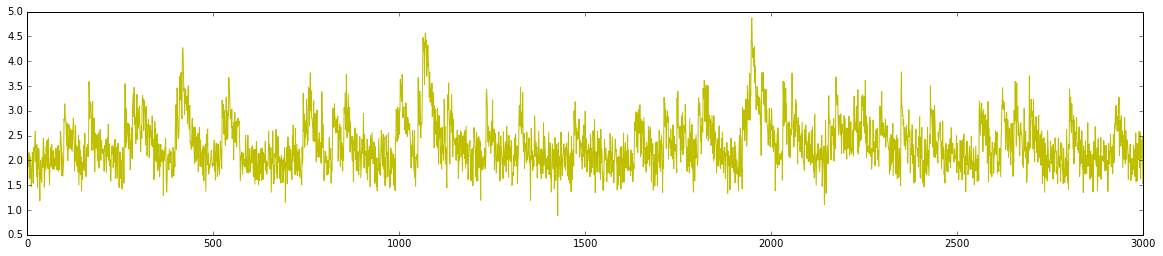

In [4]:
# here we generate some simulated fluorescence data and plot it
true_b = 2
# y, true_c, true_s = map(np.squeeze, gen_sinusoidal_data(N=1, b=true_b, seed=0))
y, true_c, true_s = map(np.squeeze, gen_data(N=1, b=true_b, seed=0))
plt.figure(figsize=(20,4))
plt.plot(y, c='y');

# Deconvolve 

### With $\ell_1$ penalty we obtain the global minimum of the convex problem 
If we only have the trace and no further info, simply calling deconvolve tries to estimate it from the data 

In [5]:
%%time
c, s, b, g, lam = deconvolve(y, penalty=1)

CPU times: user 11.5 ms, sys: 1.15 ms, total: 12.7 ms
Wall time: 11.8 ms


#### Plot results
Because we happen to have ground truth data, we show it too 

Correlation of deconvolved activity  with ground truth ('spikes') : 0.8889
Correlation of denoised fluorescence with ground truth ('calcium'): 0.9795


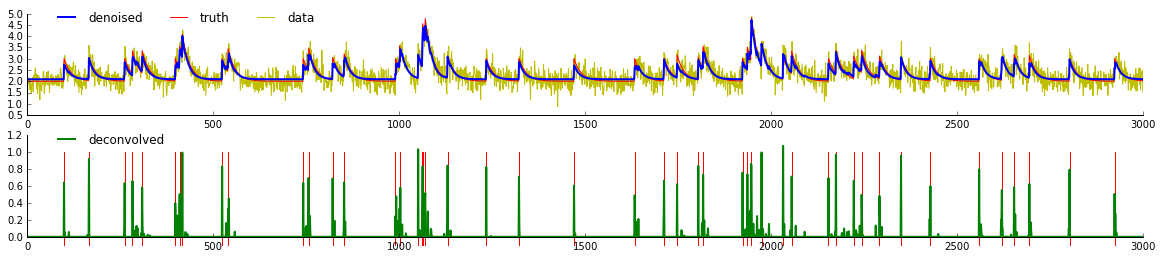

In [6]:
plot_trace(True)

### With $\ell_0$ penalty the problem is non-convex, however, we obtain a good local minimum

In [7]:
%%time
c, s, b, g, lam = deconvolve(y, penalty=0)

CPU times: user 12.8 ms, sys: 1.03 ms, total: 13.9 ms
Wall time: 13.1 ms


Correlation of deconvolved activity  with ground truth ('spikes') : 0.9046
Correlation of denoised fluorescence with ground truth ('calcium'): 0.9815


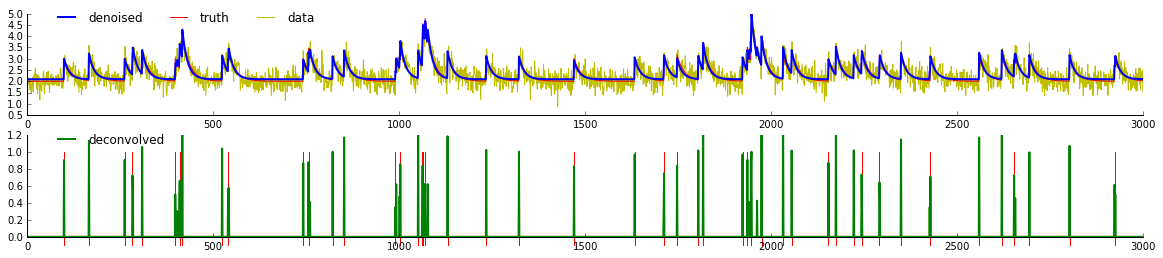

In [8]:
plot_trace(True)

### If we have a good idea about the fluorescence baseline, its time constant and it size for 1AP, we can provide this information

In [9]:
%%time
# Here we provide the ground truth values for b and g. 
# The Ca response kernel to 1 AP has maximal aplitude 1 and we pick s_min slightly larger than 1/2.
c, s = oasisAR1(y-true_b, .95, s_min=.55)

CPU times: user 3.96 ms, sys: 246 µs, total: 4.21 ms
Wall time: 4.02 ms


Correlation of deconvolved activity  with ground truth ('spikes') : 0.9120
Correlation of denoised fluorescence with ground truth ('calcium'): 0.9894


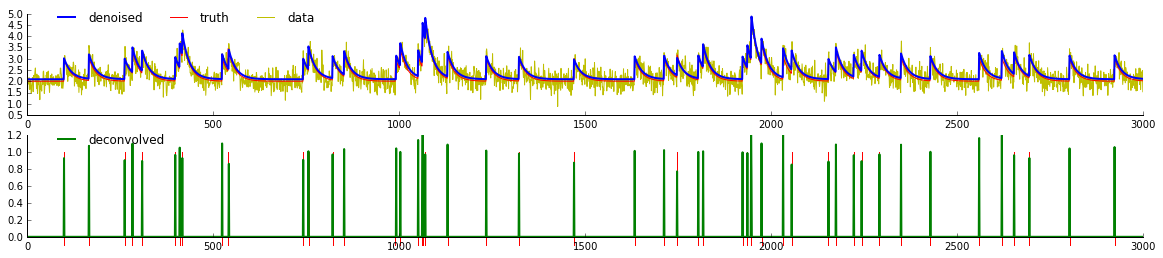

In [10]:
plot_trace(True)

# Load raw fluorescence data 
This data happend to have a slow rise time and we model it with an AR(2) process

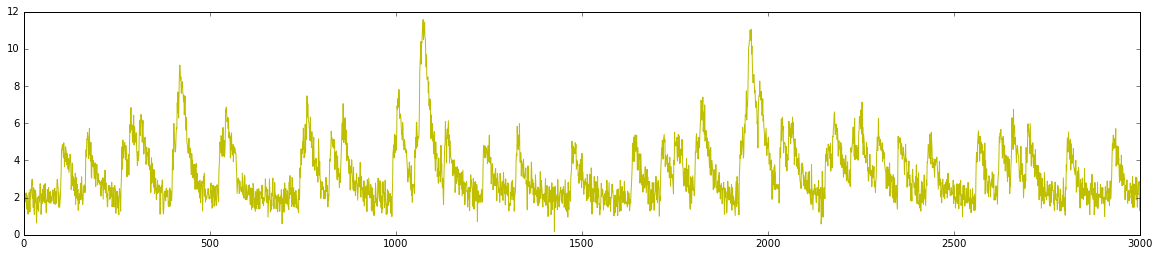

In [11]:
# here we generate some simulated fluorescence data and plot it
y, true_c, true_s = map(np.squeeze, gen_data([1.7,-.712], sn=.5, N=1, b=true_b, seed=0))
plt.figure(figsize=(20,4))
plt.plot(y, c='y');

# Deconvolve 

### With $\ell_1$ penalty we obtain the global minimum of the convex problem 
If we only have the trace and no further info, simply calling deconvolve tries to estimate it from the data 

In [12]:
%%time
# (None,None) because we want to use an AR(2) model, but don't know the parameters
c, s, b, g, lam = deconvolve(y, (None,None), penalty=1) 

CPU times: user 37.1 ms, sys: 2.58 ms, total: 39.7 ms
Wall time: 37.7 ms


Correlation of deconvolved activity  with ground truth ('spikes') : 0.6194
Correlation of denoised fluorescence with ground truth ('calcium'): 0.9948


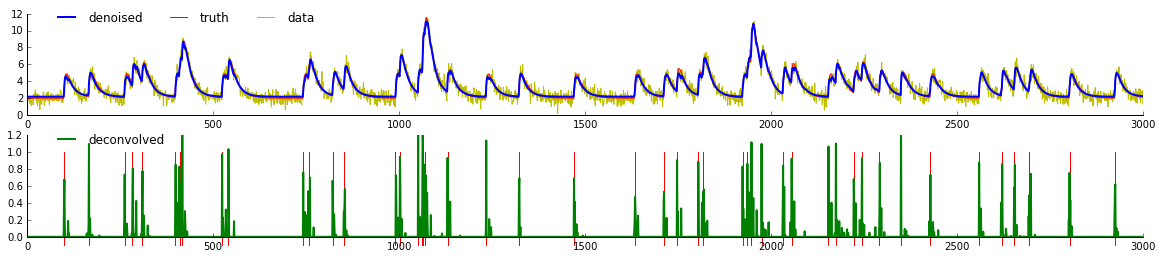

In [13]:
plot_trace(True)

### With $\ell_0$ penalty the problem is non-convex, however, we obtain a good local minimum

In [14]:
%%time
c, s, b, g, lam = deconvolve(y, (None,None), penalty=0)

CPU times: user 50.6 ms, sys: 3.71 ms, total: 54.3 ms
Wall time: 51.7 ms


Correlation of deconvolved activity  with ground truth ('spikes') : 0.6047
Correlation of denoised fluorescence with ground truth ('calcium'): 0.9941


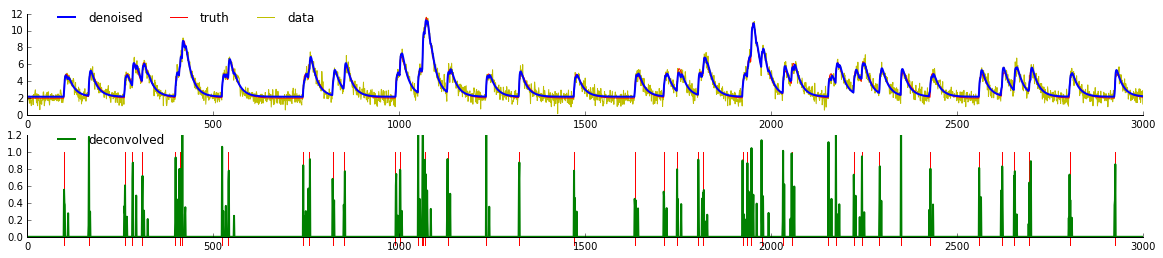

In [15]:
plot_trace(True)

### If we have a good idea about the fluorescence baseline, and its time constants we can provide this information

In [16]:
%%time
# Here we provide the ground truth values for g. 
c, s, b, g, lam = deconvolve(y, (1.7,-.712))

CPU times: user 35.5 ms, sys: 3.23 ms, total: 38.7 ms
Wall time: 36.6 ms


Correlation of deconvolved activity  with ground truth ('spikes') : 0.7787
Correlation of denoised fluorescence with ground truth ('calcium'): 0.9968


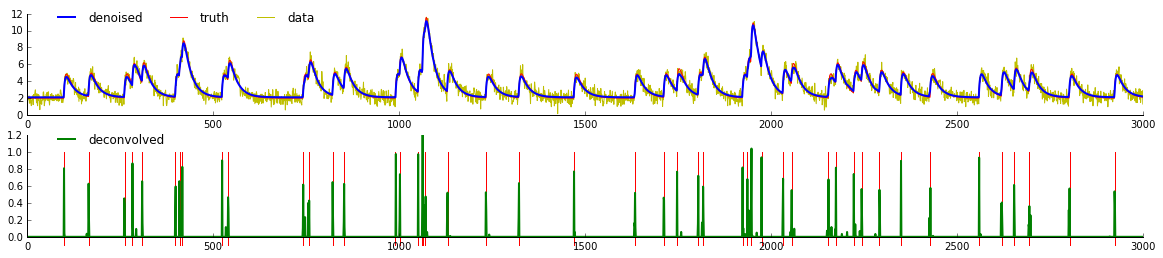

In [17]:
plot_trace(True)

#### We can also opt for a quick but less accurate greedy method 

In [18]:
%%time
# Here we provide the ground truth values for b and g and we pick s_min slightly larger than 1/2.
c, s = oasisAR2(y-true_b, 1.7,-.712, s_min=.55)

CPU times: user 13.5 ms, sys: 3.9 ms, total: 17.4 ms
Wall time: 14.3 ms


Correlation of deconvolved activity  with ground truth ('spikes') : 0.7199
Correlation of denoised fluorescence with ground truth ('calcium'): 0.9973


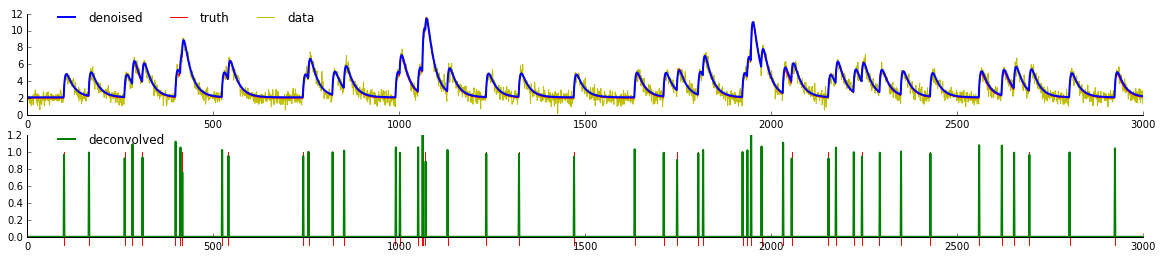

In [19]:
plot_trace(True)